In [1]:
from firedrake import *
import matplotlib.pyplot as plt

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [5]:
ncells = 100
L = 10.
mesh = PeriodicIntervalMesh(ncells, L)

V = FunctionSpace(mesh, "HER", 3)

un = Function(V)
unp1 = Function(V)

uh = (un + unp1)/2

v = TestFunction(V)

dt = 0.01
dT = Constant(dt)

# alpha = Constant(1.0)
# beta = Constant(0.02923)
# gamma = Constant(1.)

nu = Constant(0.029)

eqn = (
    v*(unp1 - un)
    - dT*v.dx(0)*uh.dx(0)
    + dT*nu*v.dx(0).dx(0)*uh.dx(0).dx(0)
    - dT*0.5*v.dx(0)*uh*uh
    )*dx

params = {
    "snes_atol": 1.0e-50,
    "snes_rtol": 1.0e-6,
    "snes_stol": 1.0e-50,
    "ksp_type":"preonly",
    "pc_type":"lu"
}

#make the solver
KSProb = NonlinearVariationalProblem(eqn, unp1)
KSSolver = NonlinearVariationalSolver(KSProb,
                                      solver_parameters=params)

#initial condition

x, = SpatialCoordinate(mesh)
un.project(-sin(pi*2*x/L))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f3e029b2b90>, FiniteElement('Hermite', interval, 3), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 19)), 33)

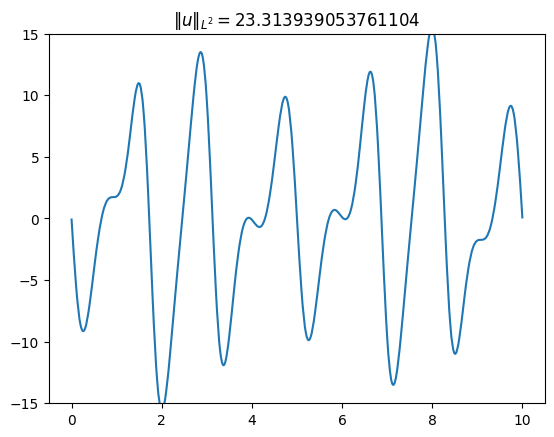

KeyboardInterrupt: 

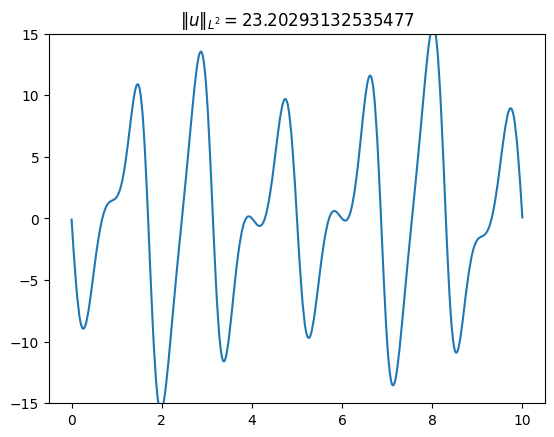

In [6]:
import time
from IPython import display

t=0.
tmax = 10.
tdump = 1.
dumpt = 0.

# file0 = File("stuff.pvd")
VOut = FunctionSpace(mesh, "CG", 3)
uout = Function(VOut)
uout.interpolate(un)
# file0.write(uout)

fig, axes = plt.subplots()
hdisplay = display.display("", display_id=True)

observable = []
t_range = []
integrals = []
while t < tmax - dt/2:
    axes.cla()
    axes.set_ylim([-15, 15])

    t += dt

    KSSolver.solve()
    un.assign(unp1)


    uout.interpolate(un)
    
    curr_norm = norm(un)
    curr_int = assemble(un * dx)
    integrals.append(curr_int)
    observable.append(curr_norm)
    t_range.append(t)
    
    axes.set_title("$\Vert u \Vert_{L^2} = " + f"{curr_norm}$")

    plot(uout, axes=axes)
    hdisplay.update(fig)
    

fig.close()


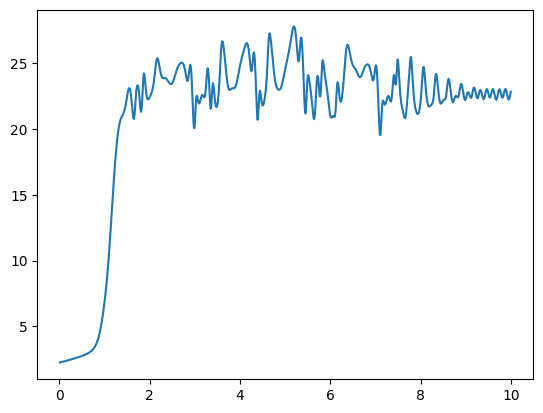

In [ ]:
plt.plot(t_range, observable)

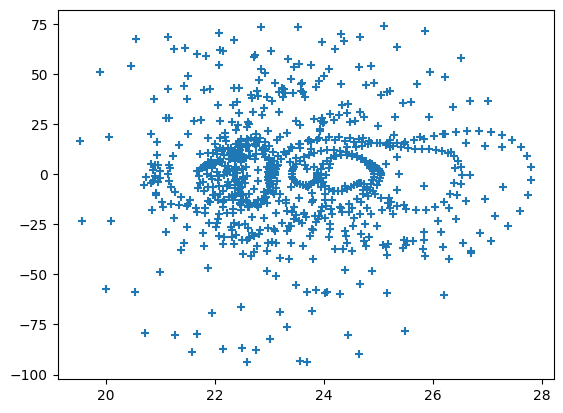

In [ ]:

observable = np.array(observable)
dEdt = np.gradient(observable, dt)

plt.scatter(observable[200:], dEdt[200:], marker="+")

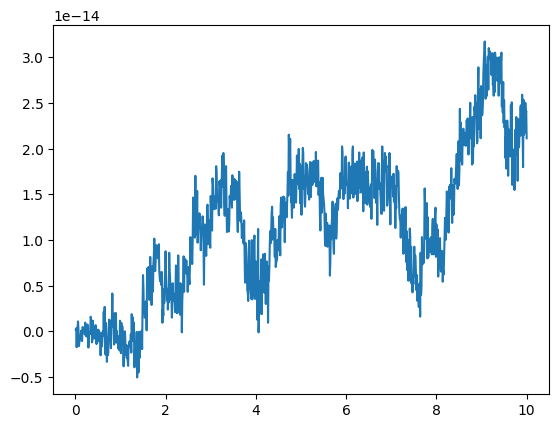

In [ ]:
# The error is close to zero
plt.plot(t_range, integrals)

In [46]:
import torch

N = 4096
L = 10.
T = 0.1
nu = 0.029
dt = 0.01
samples = 1

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/meshes/N{N}.h5", "r") as f:
    mesh = f.load_mesh()
    
fs = FunctionSpace(mesh, "HER", 3) 
fs_out = FunctionSpace(mesh, "CG", 3)


data = torch.load(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/samples/N{N}_nu{nu}_T{T}_samples{samples}_batch1.pt")

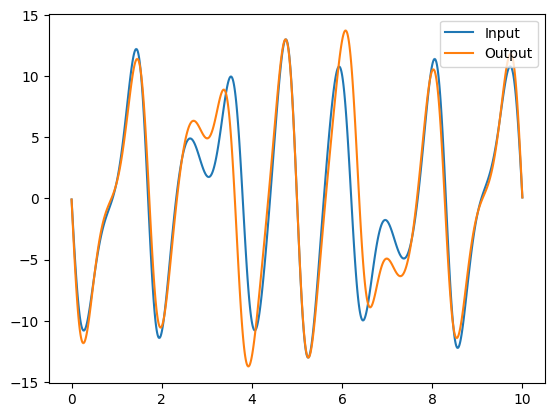

In [49]:
index = 0

func_in_her = Function(fs, val=data[index, 0, :].numpy())
func_out_her = Function(fs, val=data[index, 1, :].numpy())

func_in = Function(fs_out)
func_out = Function(fs_out)

func_in.interpolate(func_in_her)
func_out.interpolate(func_out_her)

fig, axes = plt.subplots()

plot(func_in, axes=axes, label="Input")
plot(func_out, axes=axes, label="Output")
axes.legend()

In [43]:
mesh = PeriodicIntervalMesh(64, 10)
with CheckpointFile("/tmp/np923/N64.h5", "w") as f:
    f.save_mesh(mesh)